# Setup

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Variables & Training/Equation Data

Dimensions of time numpy array
(6,)
Dimensions of distance numpy array
(6,)


Text(0.5, 0, 'Time (s)')

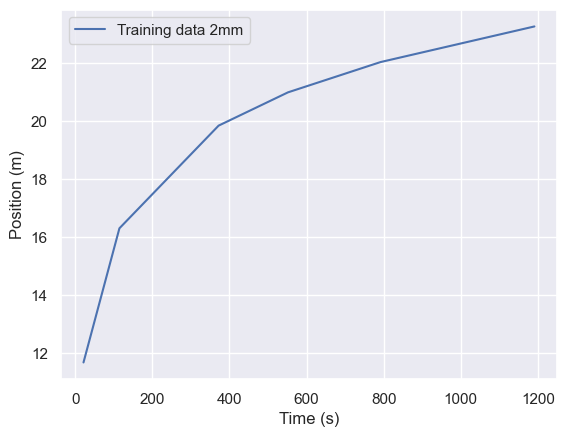

In [7]:
# Different variables for problem
r = 0.005                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(10**-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                  # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv        # Derivative of magnetic field with respect to distance in [KA/m^2]

# # Make data from equation
# eq = functools.partial(position)
# t = np.linspace(0, 1000, 1000)      # Time in [s]
# x = eq(t)                           # Position in [m]

# Make training data
train_t, train_x = position_2mm_droplet()
print('Dimensions of time numpy array')
print(train_t.shape)
print('Dimensions of distance numpy array')
print(train_x.shape)

# Plot training data and equation data
# plt.plot(t, x, 'o')
plt.plot(train_t, train_x)
# plt.legend(['Equation', 'Training data'])
plt.legend(['Training data 2mm'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')

# Physics Loss Model

In [18]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

In [19]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

Epoch 0/30000, loss: inf


KeyboardInterrupt: 

Text(0.5, 0, 'Time (s)')

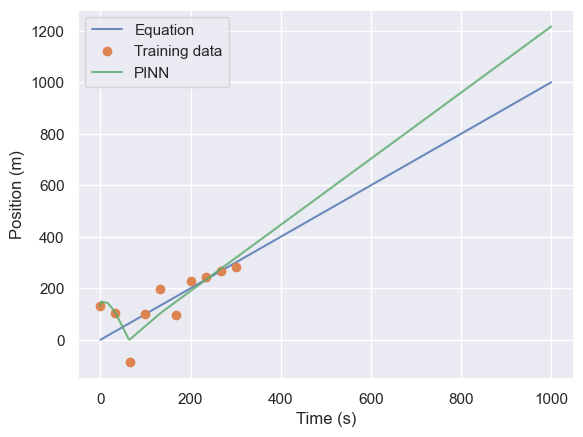

In [8]:
preds = net.predict(t)

plt.plot(t, x, alpha=0.8)
plt.plot(train_t, train_x, 'o')
plt.plot(t, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')